# Depth vs Encoding Aliasing: Does GNN Message Passing Compensate for Walk Resolution Limits?

This notebook demonstrates the experiment from the paper, which tests whether **increasing GNN depth (2→8 layers)** compensates for RWSE spectral aliasing by narrowing the RWSE-vs-LapPE performance gap.

**Setup:**
- **Model**: GCN + GlobalAttention with configurable depth
- **Encodings**: RWSE (Random Walk Structural Encoding), LapPE (Laplacian Positional Encoding), SRWE (Super-Resolution Walk Encoding)
- **Dataset**: ZINC-subset (molecular graphs, regression)
- **Metrics**: Test MAE, RWSE-LapPE gap by depth, SRI-gap correlation

**Key findings from the full experiment:**
1. On ZINC, the RWSE-LapPE gap does NOT narrow with depth (gap reduction = -9.18%)
2. On Peptides-struct, the gap converges toward zero (gap reduction = -96.28%)
3. SRI-gap correlation is weak on ZINC but moderate on Peptides-struct
4. SRWE does not outperform RWSE on either dataset

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# Packages NOT pre-installed on Colab (always install everywhere)
_pip('loguru==0.7.3')
_pip('psutil==7.0.0')

# Core packages (pre-installed on Colab, install locally to match Colab env)
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'scipy==1.16.3', 'matplotlib==3.10.0')
    _pip('torch==2.9.0+cpu', '--index-url', 'https://download.pytorch.org/whl/cpu')

# torch_geometric — NOT pre-installed on Colab, always install
_pip('torch-geometric==2.6.1')


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


## Imports

In [2]:
import json
import math
import os
import sys
import time

import numpy as np
import scipy
import scipy.linalg
from scipy.stats import spearmanr

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.nn import GCNConv, global_add_pool
from torch_geometric.data import Data, Batch

import matplotlib.pyplot as plt

from loguru import logger

# Logging setup for notebook
logger.remove()
logger.add(sys.stdout, level="INFO", format="{time:HH:mm:ss}|{level:<7}|{message}")

# Hardware detection
HAS_GPU = torch.cuda.is_available()
DEVICE = torch.device("cuda" if HAS_GPU else "cpu")
print(f"Device: {DEVICE}, GPU available: {HAS_GPU}")

Device: cpu, GPU available: False


## Load Data

Load graph data from the demo dataset. Uses GitHub URL with local fallback.

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-ace67e-the-walk-resolution-limit-a-super-resolu/main/experiment_iter5_depth_vs_encodi/demo/mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()

# Show data summary
for ds in data["datasets"]:
    print(f"Dataset: {ds['dataset']}, examples: {len(ds['examples'])}")
    ex0 = ds['examples'][0]
    inp0 = json.loads(ex0['input'])
    print(f"  First example: num_nodes={inp0['num_nodes']}, spectral keys={list(inp0['spectral'].keys())}")

Dataset: ZINC-subset, examples: 30
  First example: num_nodes=24, spectral keys=['eigenvalues', 'delta_min', 'sri', 'vandermonde_cond', 'rwse', 'local_spectral']


## Configuration

All tunable experiment parameters. Values are set for a quick demo; original full-experiment values are shown in comments.

In [5]:
# ── Tunable parameters ──
PE_DIM = 20               # Original: 20
HIDDEN_DIM = 64            # Original: 64
DEPTHS = [2, 3, 4, 6, 8]  # Original: [2, 3, 4, 6, 8]
PE_TYPES = ["rwse", "lappe", "srwe"]  # Original: ["rwse", "lappe", "srwe"]
SEEDS = [0, 1, 2]         # Original: [0, 1, 2]
MAX_EPOCHS = 100           # Original: 100
PATIENCE = 20              # Original: 20
LR = 1e-3                  # Original: 1e-3
DROPOUT = 0.1              # Original: 0.1
BATCH_SIZE = 16            # Original: 64
MAX_NODES_SPECTRAL = 200   # Original: 200

## Graph Parsing

Parse raw JSON examples into graph components: edge indices, node features, spectral data (eigenvalues, RWSE), and regression targets.

In [6]:
def parse_graph(example: dict) -> dict:
    """Parse a single example into graph components."""
    inp = json.loads(example["input"])
    edge_index = np.array(inp["edge_index"], dtype=np.int64)
    num_nodes = inp["num_nodes"]
    node_feat = np.array(inp["node_feat"], dtype=np.float32)
    spectral = inp["spectral"]
    eigenvalues = np.array(spectral["eigenvalues"], dtype=np.float64)
    rwse = np.array(spectral["rwse"], dtype=np.float32)  # [N, 20]
    sri = spectral.get("sri", {})

    output_str = example["output"]
    try:
        output = json.loads(output_str)
        if isinstance(output, list):
            target = np.array(output, dtype=np.float32)
        else:
            target = np.array([float(output)], dtype=np.float32)
    except (json.JSONDecodeError, ValueError):
        target = np.array([float(output_str)], dtype=np.float32)

    return {
        "edge_index": edge_index,
        "num_nodes": num_nodes,
        "node_feat": node_feat,
        "eigenvalues": eigenvalues,
        "rwse": rwse,
        "target": target,
        "sri": sri,
        "metadata_fold": example.get("metadata_fold", 0),
        "metadata_row_index": example.get("metadata_row_index", 0),
        "delta_min": spectral.get("delta_min", 0.0),
    }

# Parse all ZINC graphs from loaded data
raw_datasets = {}
for ds_block in data["datasets"]:
    raw_datasets[ds_block["dataset"]] = ds_block["examples"]

examples = raw_datasets.get("ZINC-subset", [])
logger.info(f"Parsing {len(examples)} ZINC-subset examples")
parsed_graphs = []
for i, ex in enumerate(examples):
    try:
        g = parse_graph(ex)
        g["_idx"] = i
        g["_dataset"] = "ZINC-subset"
        parsed_graphs.append(g)
    except Exception as e:
        logger.warning(f"Failed to parse example {i}: {e}")

logger.info(f"Parsed {len(parsed_graphs)} graphs")

19:34:18|INFO   |Parsing 30 ZINC-subset examples


19:34:18|INFO   |Parsed 30 graphs


## Spectral Preprocessing

Compute eigendecomposition of normalized adjacency matrices, then derive three types of positional encodings:
- **RWSE**: Random Walk Structural Encoding (directly from spectral data)
- **LapPE**: Laplacian Positional Encoding (squared eigenvectors)
- **SRWE**: Super-Resolution Walk Encoding (Tikhonov-regularized spectral decomposition of RWSE)

In [7]:
def compute_normalized_adjacency_eigen(edge_index: np.ndarray, num_nodes: int):
    """Compute eigenvalues/vectors of normalized adjacency D^{-1/2} A D^{-1/2}."""
    if num_nodes > MAX_NODES_SPECTRAL:
        return None, None

    A = np.zeros((num_nodes, num_nodes), dtype=np.float64)
    src = edge_index[0]
    dst = edge_index[1]
    A[src, dst] = 1.0

    deg = A.sum(axis=1)
    deg_inv_sqrt = np.zeros(num_nodes, dtype=np.float64)
    mask = deg > 0
    deg_inv_sqrt[mask] = 1.0 / np.sqrt(deg[mask])

    P = A * deg_inv_sqrt[:, None] * deg_inv_sqrt[None, :]

    try:
        eigenvalues, eigenvectors = scipy.linalg.eigh(P)
    except Exception as e:
        logger.warning(f"Eigendecomposition failed: {e}")
        return None, None

    return eigenvalues, eigenvectors


def compute_srwe_batch(rwse_all: np.ndarray, eigenvalues_P: np.ndarray, alpha: float = 1e-4) -> np.ndarray:
    """Vectorized SRWE computation for ALL nodes in a graph at once."""
    K = rwse_all.shape[1]
    N_eig = eigenvalues_P.shape[0]

    powers = np.arange(1, K + 1, dtype=np.float64)[:, None]
    eigs = eigenvalues_P[None, :]
    V = np.power(eigs, powers)

    VtV = V.T @ V + alpha * np.eye(N_eig, dtype=np.float64)
    VtM = V.T @ rwse_all.astype(np.float64).T

    try:
        W = scipy.linalg.solve(VtV, VtM, assume_a='pos')
    except np.linalg.LinAlgError:
        W = np.linalg.lstsq(VtV, VtM, rcond=None)[0]

    W = W.T
    W = np.maximum(W, 0.0)
    row_sums = W.sum(axis=1, keepdims=True)
    row_sums = np.where(row_sums > 1e-12, row_sums, 1.0)
    W = W / row_sums

    return W


def compute_pe(graph_data: dict, pe_type: str, eigenvalues_P=None, eigenvectors_P=None) -> np.ndarray:
    """Compute positional encoding for a graph. Returns [num_nodes, PE_DIM] array."""
    num_nodes = graph_data["num_nodes"]
    rwse = graph_data["rwse"]

    if pe_type == "rwse":
        pe = rwse[:, :PE_DIM]
        if pe.shape[1] < PE_DIM:
            pe = np.pad(pe, ((0, 0), (0, PE_DIM - pe.shape[1])))
        return pe.astype(np.float32)

    elif pe_type == "lappe":
        if eigenvectors_P is not None and eigenvectors_P.shape[0] == num_nodes:
            evecs_sq = eigenvectors_P ** 2
            if evecs_sq.shape[1] >= PE_DIM:
                pe = evecs_sq[:, :PE_DIM]
            else:
                pe = np.pad(evecs_sq, ((0, 0), (0, PE_DIM - evecs_sq.shape[1])))
            return pe.astype(np.float32)
        else:
            pe = rwse[:, :PE_DIM]
            if pe.shape[1] < PE_DIM:
                pe = np.pad(pe, ((0, 0), (0, PE_DIM - pe.shape[1])))
            return pe.astype(np.float32)

    elif pe_type == "srwe":
        if eigenvalues_P is not None and eigenvalues_P.shape[0] == num_nodes:
            W = compute_srwe_batch(rwse, eigenvalues_P)
            bin_edges = np.linspace(-1.0, 1.0, PE_DIM + 1)
            bin_indices = np.digitize(eigenvalues_P, bin_edges) - 1
            bin_indices = np.clip(bin_indices, 0, PE_DIM - 1)
            pe = np.zeros((num_nodes, PE_DIM), dtype=np.float64)
            for b in range(PE_DIM):
                mask = bin_indices == b
                if mask.any():
                    pe[:, b] = W[:, mask].sum(axis=1)
            return pe.astype(np.float32)
        else:
            pe = rwse[:, :PE_DIM]
            if pe.shape[1] < PE_DIM:
                pe = np.pad(pe, ((0, 0), (0, PE_DIM - pe.shape[1])))
            return pe.astype(np.float32)
    else:
        raise ValueError(f"Unknown pe_type: {pe_type}")

## GCN + GlobalAttention Model

The model architecture: GCN layers with residual connections and BatchNorm, followed by a gated global attention pooling mechanism and a 2-layer MLP head for regression.

In [8]:
class GCN_GlobalAttention(nn.Module):
    """GCN with configurable depth and global attention pooling."""

    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int,
                 num_layers: int, dropout: float = 0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            self.bns.append(nn.BatchNorm1d(hidden_dim))
        self.dropout = dropout

        self.gate_nn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x, edge_index, batch):
        h = F.relu(self.input_proj(x))
        for conv, bn in zip(self.convs, self.bns):
            h_new = conv(h, edge_index)
            h_new = bn(h_new)
            h_new = F.relu(h_new)
            h_new = F.dropout(h_new, p=self.dropout, training=self.training)
            h = h + h_new  # residual

        gate = torch.sigmoid(self.gate_nn(h))
        h_weighted = h * gate
        h_graph = global_add_pool(h_weighted, batch)
        return self.head(h_graph)

## Training & Evaluation Utilities

Data preparation (PE caching, PyG conversion), training loop with early stopping, and evaluation.

In [9]:
# ── PE Caching ──
def precompute_all_pe(graphs: list, eigen_cache: dict) -> dict:
    """Precompute PE arrays for all 3 PE types for all graphs."""
    pe_cache = {}
    for g in graphs:
        idx = g["_idx"]
        ev_P, evec_P = eigen_cache.get(idx, (None, None))
        for pe_type in PE_TYPES:
            pe = compute_pe(g, pe_type, eigenvalues_P=ev_P, eigenvectors_P=evec_P)
            pe_cache[(idx, pe_type)] = pe
    return pe_cache


def prepare_pyg_data_cached(graphs: list, pe_type: str, pe_cache: dict) -> list:
    """Convert parsed graph dicts to PyG Data using precomputed PE."""
    data_list = []
    for g in graphs:
        idx = g["_idx"]
        pe = pe_cache[(idx, pe_type)]
        x = np.concatenate([g["node_feat"], pe], axis=1)
        x_tensor = torch.tensor(x, dtype=torch.float32)
        edge_index_tensor = torch.tensor(g["edge_index"], dtype=torch.long)
        y_tensor = torch.tensor(g["target"], dtype=torch.float32)
        d = Data(x=x_tensor, edge_index=edge_index_tensor, y=y_tensor, num_nodes=g["num_nodes"])
        data_list.append(d)
    return data_list


def collate_batch(data_list):
    return Batch.from_data_list(data_list)


def make_dataloader(data_list, batch_size, shuffle=False):
    if shuffle:
        indices = np.random.permutation(len(data_list))
        data_list = [data_list[i] for i in indices]
    batches = []
    for i in range(0, len(data_list), batch_size):
        chunk = data_list[i:i + batch_size]
        batches.append(collate_batch(chunk))
    return batches


# ── Training ──
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    n_samples = 0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred = model(batch.x, batch.edge_index, batch.batch)
        target = batch.y.view(pred.shape)
        loss = F.l1_loss(pred, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * pred.size(0)
        n_samples += pred.size(0)
    return total_loss / max(n_samples, 1)


@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    n_samples = 0
    all_preds = []
    all_targets = []
    for batch in dataloader:
        batch = batch.to(device)
        pred = model(batch.x, batch.edge_index, batch.batch)
        target = batch.y.view(pred.shape)
        loss = F.l1_loss(pred, target)
        total_loss += loss.item() * pred.size(0)
        n_samples += pred.size(0)
        all_preds.append(pred.cpu().numpy())
        all_targets.append(target.cpu().numpy())

    mae = total_loss / max(n_samples, 1)
    preds = np.concatenate(all_preds, axis=0)
    targets = np.concatenate(all_targets, axis=0)
    return mae, preds, targets


def train_model(train_data, val_data, input_dim, output_dim, depth, seed,
                max_epochs=None, patience=None, lr=LR, dropout=DROPOUT, device=DEVICE):
    """Train a GCN model with early stopping."""
    if max_epochs is None:
        max_epochs = MAX_EPOCHS
    if patience is None:
        patience = PATIENCE

    torch.manual_seed(seed)
    np.random.seed(seed)

    actual_dropout = dropout
    actual_lr = lr
    if depth >= 6:
        actual_lr = 5e-4
        actual_dropout = 0.2

    model = GCN_GlobalAttention(
        input_dim=input_dim, hidden_dim=HIDDEN_DIM,
        output_dim=output_dim, num_layers=depth, dropout=actual_dropout,
    ).to(device)

    optimizer = Adam(model.parameters(), lr=actual_lr)
    best_val_mae = float("inf")
    best_state = None
    patience_counter = 0

    for epoch in range(max_epochs):
        train_loader = make_dataloader(train_data, BATCH_SIZE, shuffle=True)
        train_one_epoch(model, train_loader, optimizer, device)

        val_loader = make_dataloader(val_data, BATCH_SIZE, shuffle=False)
        val_mae, _, _ = evaluate(model, val_loader, device)

        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_state = {k: v.clone() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_val_mae


# ── Data Splitting ──
def random_split(graphs, train_frac=0.7, val_frac=0.15):
    np.random.seed(42)
    indices = np.random.permutation(len(graphs))
    n = len(graphs)
    n_train = max(int(n * train_frac), 1)
    n_val = max(int(n * val_frac), 1)
    train = [graphs[i] for i in indices[:n_train]]
    val = [graphs[i] for i in indices[n_train:n_train + n_val]]
    test = [graphs[i] for i in indices[n_train + n_val:]]
    if not test:
        test = val  # fallback for very small datasets
    return train, val, test

## Build Eigen Cache & Precompute PE

Compute eigendecompositions for all graphs, then precompute all three PE types (RWSE, LapPE, SRWE) using the cached spectral data.

In [10]:
# Build eigen cache
logger.info(f"Building eigen cache for {len(parsed_graphs)} graphs...")
t0 = time.time()
eigen_cache = {}
for g in parsed_graphs:
    idx = g["_idx"]
    ev, evec = compute_normalized_adjacency_eigen(g["edge_index"], g["num_nodes"])
    eigen_cache[idx] = (ev, evec)
logger.info(f"Eigen cache built in {time.time()-t0:.2f}s")

# Precompute PE for all types
logger.info("Precomputing positional encodings...")
t1 = time.time()
pe_cache = precompute_all_pe(parsed_graphs, eigen_cache)
logger.info(f"PE precomputed in {time.time()-t1:.2f}s")

19:34:18|INFO   |Building eigen cache for 30 graphs...


19:34:18|INFO   |Eigen cache built in 0.00s


19:34:18|INFO   |Precomputing positional encodings...


19:34:18|INFO   |PE precomputed in 0.00s


## Experiment Loop

Train GCN models across all combinations of depth x encoding type x seed. Record test MAE and per-graph predictions for analysis.

In [11]:
# Split data
train_graphs, val_graphs, test_graphs = random_split(parsed_graphs)
logger.info(f"Split: train={len(train_graphs)}, val={len(val_graphs)}, test={len(test_graphs)}")

output_dim = 1  # ZINC regression

# Experiment loop
results = {}  # {(depth, pe_type): [mae per seed]}
per_graph_preds = {}  # {(depth, pe_type, seed): {graph_idx: (pred, target)}}

total_runs = len(DEPTHS) * len(PE_TYPES) * len(SEEDS)
logger.info(f"Running {total_runs} total training runs: {len(DEPTHS)} depths x {len(PE_TYPES)} PE types x {len(SEEDS)} seeds")
t_exp_start = time.time()

for depth in DEPTHS:
    for pe_type in PE_TYPES:
        for seed in SEEDS:
            run_key = (depth, pe_type)
            if run_key not in results:
                results[run_key] = []

            logger.info(f"  Training: depth={depth}, pe={pe_type}, seed={seed}")
            t_run = time.time()

            try:
                train_pyg = prepare_pyg_data_cached(train_graphs, pe_type, pe_cache)
                val_pyg = prepare_pyg_data_cached(val_graphs, pe_type, pe_cache)
                test_pyg = prepare_pyg_data_cached(test_graphs, pe_type, pe_cache)

                input_dim = train_pyg[0].x.size(1) if train_pyg else PE_DIM + 1

                model, best_val = train_model(
                    train_pyg, val_pyg, input_dim, output_dim, depth, seed
                )

                test_loader = make_dataloader(test_pyg, BATCH_SIZE, shuffle=False)
                test_mae, test_preds, test_targets = evaluate(model, test_loader, DEVICE)

                results[run_key].append(test_mae)
                logger.info(f"    MAE: {test_mae:.6f} (val: {best_val:.6f}, time: {time.time()-t_run:.1f}s)")

                # Store per-graph predictions
                pred_key = (depth, pe_type, seed)
                per_graph_preds[pred_key] = {}
                for i, g in enumerate(test_graphs):
                    if i < len(test_preds):
                        p = test_preds[i].tolist() if test_preds[i].ndim > 0 else [float(test_preds[i])]
                        t = test_targets[i].tolist() if test_targets[i].ndim > 0 else [float(test_targets[i])]
                        per_graph_preds[pred_key][g["_idx"]] = (p, t)

                del model
                if HAS_GPU:
                    torch.cuda.empty_cache()

            except Exception as e:
                logger.warning(f"  Failed: depth={depth}, pe={pe_type}, seed={seed}: {e}")
                results[run_key].append(float("nan"))

total_time = time.time() - t_exp_start
logger.info(f"Experiment complete: {total_runs} runs in {total_time:.1f}s")

19:34:18|INFO   |Split: train=21, val=4, test=5


19:34:18|INFO   |Running 45 total training runs: 5 depths x 3 PE types x 3 seeds


19:34:18|INFO   |  Training: depth=2, pe=rwse, seed=0


19:34:20|INFO   |    MAE: 1.098195 (val: 0.368622, time: 2.2s)


19:34:20|INFO   |  Training: depth=2, pe=rwse, seed=1


19:34:23|INFO   |    MAE: 1.325606 (val: 0.598629, time: 2.7s)


19:34:23|INFO   |  Training: depth=2, pe=rwse, seed=2


19:34:24|INFO   |    MAE: 0.940572 (val: 0.577511, time: 1.7s)


19:34:24|INFO   |  Training: depth=2, pe=lappe, seed=0


19:34:26|INFO   |    MAE: 1.378873 (val: 0.730456, time: 1.8s)


19:34:26|INFO   |  Training: depth=2, pe=lappe, seed=1


19:34:27|INFO   |    MAE: 1.602168 (val: 1.209787, time: 0.7s)


19:34:27|INFO   |  Training: depth=2, pe=lappe, seed=2


19:34:29|INFO   |    MAE: 1.016796 (val: 0.785425, time: 1.9s)


19:34:29|INFO   |  Training: depth=2, pe=srwe, seed=0


19:34:32|INFO   |    MAE: 1.245797 (val: 0.293728, time: 2.8s)


19:34:32|INFO   |  Training: depth=2, pe=srwe, seed=1


19:34:33|INFO   |    MAE: 1.572834 (val: 1.210950, time: 1.1s)


19:34:33|INFO   |  Training: depth=2, pe=srwe, seed=2


19:34:34|INFO   |    MAE: 1.071690 (val: 0.408814, time: 1.5s)


19:34:34|INFO   |  Training: depth=3, pe=rwse, seed=0


19:34:37|INFO   |    MAE: 1.038828 (val: 0.459704, time: 2.9s)


19:34:37|INFO   |  Training: depth=3, pe=rwse, seed=1


19:34:40|INFO   |    MAE: 1.056873 (val: 0.270351, time: 3.0s)


19:34:40|INFO   |  Training: depth=3, pe=rwse, seed=2


19:34:41|INFO   |    MAE: 1.360679 (val: 0.854920, time: 0.7s)


19:34:41|INFO   |  Training: depth=3, pe=lappe, seed=0


19:34:44|INFO   |    MAE: 1.078468 (val: 0.559482, time: 3.0s)


19:34:44|INFO   |  Training: depth=3, pe=lappe, seed=1


19:34:48|INFO   |    MAE: 0.895339 (val: 0.457272, time: 4.0s)


19:34:48|INFO   |  Training: depth=3, pe=lappe, seed=2


19:34:52|INFO   |    MAE: 1.378841 (val: 0.630202, time: 4.2s)


19:34:52|INFO   |  Training: depth=3, pe=srwe, seed=0


19:34:58|INFO   |    MAE: 0.921161 (val: 0.380258, time: 5.4s)


19:34:58|INFO   |  Training: depth=3, pe=srwe, seed=1


19:35:03|INFO   |    MAE: 1.272710 (val: 0.308508, time: 5.1s)


19:35:03|INFO   |  Training: depth=3, pe=srwe, seed=2


19:35:09|INFO   |    MAE: 1.282718 (val: 0.208369, time: 6.5s)


19:35:09|INFO   |  Training: depth=4, pe=rwse, seed=0


19:35:11|INFO   |    MAE: 1.327197 (val: 0.875886, time: 2.2s)


19:35:11|INFO   |  Training: depth=4, pe=rwse, seed=1


19:35:17|INFO   |    MAE: 1.207707 (val: 0.357698, time: 5.5s)


19:35:17|INFO   |  Training: depth=4, pe=rwse, seed=2


19:35:23|INFO   |    MAE: 1.589868 (val: 0.419771, time: 5.7s)


19:35:23|INFO   |  Training: depth=4, pe=lappe, seed=0


19:35:26|INFO   |    MAE: 1.351868 (val: 0.829701, time: 3.3s)


19:35:26|INFO   |  Training: depth=4, pe=lappe, seed=1


19:35:30|INFO   |    MAE: 1.697377 (val: 1.459800, time: 3.7s)


19:35:30|INFO   |  Training: depth=4, pe=lappe, seed=2


19:35:32|INFO   |    MAE: 1.335608 (val: 0.806583, time: 2.2s)


19:35:32|INFO   |  Training: depth=4, pe=srwe, seed=0


19:35:35|INFO   |    MAE: 1.411907 (val: 0.809038, time: 3.0s)


19:35:35|INFO   |  Training: depth=4, pe=srwe, seed=1


19:35:40|INFO   |    MAE: 0.938743 (val: 0.431874, time: 5.2s)


19:35:40|INFO   |  Training: depth=4, pe=srwe, seed=2


19:35:47|INFO   |    MAE: 1.220650 (val: 0.250790, time: 6.9s)


19:35:47|INFO   |  Training: depth=6, pe=rwse, seed=0


19:35:49|INFO   |    MAE: 1.511498 (val: 1.134458, time: 2.2s)


19:35:49|INFO   |  Training: depth=6, pe=rwse, seed=1


19:36:00|INFO   |    MAE: 1.239175 (val: 0.614209, time: 10.5s)


19:36:00|INFO   |  Training: depth=6, pe=rwse, seed=2


19:36:07|INFO   |    MAE: 1.096632 (val: 0.724060, time: 7.0s)


19:36:07|INFO   |  Training: depth=6, pe=lappe, seed=0


19:36:10|INFO   |    MAE: 1.471649 (val: 1.077937, time: 3.6s)


19:36:10|INFO   |  Training: depth=6, pe=lappe, seed=1


19:36:20|INFO   |    MAE: 0.714944 (val: 0.671539, time: 9.7s)


19:36:20|INFO   |  Training: depth=6, pe=lappe, seed=2


19:36:25|INFO   |    MAE: 1.257350 (val: 0.931405, time: 4.8s)


19:36:25|INFO   |  Training: depth=6, pe=srwe, seed=0


19:36:31|INFO   |    MAE: 1.444952 (val: 1.083040, time: 6.2s)


19:36:31|INFO   |  Training: depth=6, pe=srwe, seed=1


19:36:35|INFO   |    MAE: 1.481316 (val: 1.038917, time: 4.0s)


19:36:35|INFO   |  Training: depth=6, pe=srwe, seed=2


19:36:50|INFO   |    MAE: 0.990254 (val: 0.493574, time: 15.1s)


19:36:50|INFO   |  Training: depth=8, pe=rwse, seed=0


19:36:54|INFO   |    MAE: 1.356498 (val: 0.913457, time: 4.3s)


19:36:54|INFO   |  Training: depth=8, pe=rwse, seed=1


19:37:04|INFO   |    MAE: 1.595774 (val: 0.379326, time: 9.4s)


19:37:04|INFO   |  Training: depth=8, pe=rwse, seed=2


19:37:16|INFO   |    MAE: 1.127006 (val: 0.905439, time: 12.1s)


19:37:16|INFO   |  Training: depth=8, pe=lappe, seed=0


19:37:24|INFO   |    MAE: 1.171135 (val: 0.762334, time: 8.6s)


19:37:24|INFO   |  Training: depth=8, pe=lappe, seed=1


19:37:28|INFO   |    MAE: 1.463454 (val: 1.113814, time: 3.6s)


19:37:28|INFO   |  Training: depth=8, pe=lappe, seed=2


19:37:34|INFO   |    MAE: 1.415663 (val: 1.144331, time: 5.5s)


19:37:34|INFO   |  Training: depth=8, pe=srwe, seed=0


19:37:41|INFO   |    MAE: 1.106318 (val: 0.528802, time: 7.6s)


19:37:41|INFO   |  Training: depth=8, pe=srwe, seed=1


19:37:44|INFO   |    MAE: 1.440987 (val: 1.226373, time: 2.6s)


19:37:44|INFO   |  Training: depth=8, pe=srwe, seed=2


19:37:54|INFO   |    MAE: 1.328646 (val: 1.090715, time: 10.1s)


19:37:54|INFO   |Experiment complete: 45 runs in 216.1s


## Analysis

Compute the key metrics:
1. **Mean MAE** per (depth, encoding) condition
2. **Gap analysis**: RWSE-vs-LapPE gap by depth (does it narrow?)
3. **SRI correlation**: Spearman correlation between SRI values and per-graph RWSE-LapPE error difference
4. **SRWE advantage**: Does SRWE outperform RWSE?

In [12]:
# 1. Aggregate results
print("=" * 60)
print("RESULTS: Mean MAE per (depth, PE type)")
print("=" * 60)
depth_encoding_results = {}
for (d, pe), maes in sorted(results.items()):
    valid = [m for m in maes if not np.isnan(m)]
    mean_mae = float(np.mean(valid)) if valid else float("nan")
    std_mae = float(np.std(valid)) if valid else float("nan")
    key_str = f"depth{d}_{pe}"
    depth_encoding_results[key_str] = {
        "depth": d, "pe_type": pe,
        "mean_mae": round(mean_mae, 6), "std_mae": round(std_mae, 6),
        "n_seeds": len(valid),
    }
    print(f"  {key_str}: {mean_mae:.4f} +/- {std_mae:.4f}")

# 2. Gap analysis (RWSE - LapPE)
print("\n" + "=" * 60)
print("GAP ANALYSIS: RWSE - LapPE MAE by depth")
print("=" * 60)
gap_by_depth = {}
for d in DEPTHS:
    rk = (d, "rwse")
    lk = (d, "lappe")
    if rk in results and lk in results:
        rv = [m for m in results[rk] if not np.isnan(m)]
        lv = [m for m in results[lk] if not np.isnan(m)]
        if rv and lv:
            gap = float(np.mean(rv) - np.mean(lv))
            gap_by_depth[d] = gap
            print(f"  depth={d}: gap = {gap:.6f} (RWSE={np.mean(rv):.4f}, LapPE={np.mean(lv):.4f})")

if len(gap_by_depth) >= 2:
    sorted_d = sorted(gap_by_depth.keys())
    first_gap = gap_by_depth[sorted_d[0]]
    last_gap = gap_by_depth[sorted_d[-1]]
    if abs(first_gap) > 1e-8:
        reduction = (first_gap - last_gap) / abs(first_gap) * 100
        print(f"\n  Gap reduction: {reduction:.1f}% (positive = gap narrows with depth)")

# 3. SRI-gap correlation
print("\n" + "=" * 60)
print("SRI-GAP CORRELATION (Spearman)")
print("=" * 60)
for d in DEPTHS:
    diff_errors = []
    sris = []
    for seed in SEEDS:
        rk = (d, "rwse", seed)
        lk = (d, "lappe", seed)
        if rk not in per_graph_preds or lk not in per_graph_preds:
            continue
        rp = per_graph_preds[rk]
        lp = per_graph_preds[lk]
        for g in test_graphs:
            idx = g["_idx"]
            if idx in rp and idx in lp:
                re = float(np.mean(np.abs(np.array(rp[idx][0]) - np.array(rp[idx][1]))))
                le = float(np.mean(np.abs(np.array(lp[idx][0]) - np.array(lp[idx][1]))))
                diff_errors.append(re - le)
                sris.append(g["sri"].get("K=20", g["sri"].get("K=16", 0.0)))

    if len(diff_errors) >= 3:
        rho, pval = spearmanr(sris, diff_errors)
        print(f"  depth={d}: rho={rho:.4f}, p={pval:.4f} (n={len(diff_errors)})")
    else:
        print(f"  depth={d}: insufficient data ({len(diff_errors)} samples)")

# 4. SRWE advantage
print("\n" + "=" * 60)
print("SRWE ADVANTAGE: SRWE - RWSE MAE by depth")
print("=" * 60)
srwe_adv = {}
for d in DEPTHS:
    sk = (d, "srwe")
    rk = (d, "rwse")
    if sk in results and rk in results:
        sv = [m for m in results[sk] if not np.isnan(m)]
        rv = [m for m in results[rk] if not np.isnan(m)]
        if sv and rv:
            adv = float(np.mean(sv) - np.mean(rv))
            srwe_adv[d] = adv
            print(f"  depth={d}: SRWE-RWSE = {adv:.6f} (positive = SRWE worse)")

RESULTS: Mean MAE per (depth, PE type)
  depth2_lappe: 1.3326 +/- 0.2412
  depth2_rwse: 1.1215 +/- 0.1580
  depth2_srwe: 1.2968 +/- 0.2077
  depth3_lappe: 1.1175 +/- 0.1993
  depth3_rwse: 1.1521 +/- 0.1477
  depth3_srwe: 1.1589 +/- 0.1681
  depth4_lappe: 1.4616 +/- 0.1668
  depth4_rwse: 1.3749 +/- 0.1596
  depth4_srwe: 1.1904 +/- 0.1943
  depth6_lappe: 1.1480 +/- 0.3185
  depth6_rwse: 1.2824 +/- 0.1721
  depth6_srwe: 1.3055 +/- 0.2234
  depth8_lappe: 1.3501 +/- 0.1280
  depth8_rwse: 1.3598 +/- 0.1914
  depth8_srwe: 1.2920 +/- 0.1391

GAP ANALYSIS: RWSE - LapPE MAE by depth
  depth=2: gap = -0.211155 (RWSE=1.1215, LapPE=1.3326)
  depth=3: gap = 0.034577 (RWSE=1.1521, LapPE=1.1175)
  depth=4: gap = -0.086694 (RWSE=1.3749, LapPE=1.4616)
  depth=6: gap = 0.134454 (RWSE=1.2824, LapPE=1.1480)
  depth=8: gap = 0.009675 (RWSE=1.3598, LapPE=1.3501)

  Gap reduction: -104.6% (positive = gap narrows with depth)

SRI-GAP CORRELATION (Spearman)
  depth=2: rho=0.3382, p=0.2175 (n=15)
  depth=3: rho=

## Visualization

Plot the key results: MAE by depth for each encoding type, and the RWSE-LapPE gap trend.

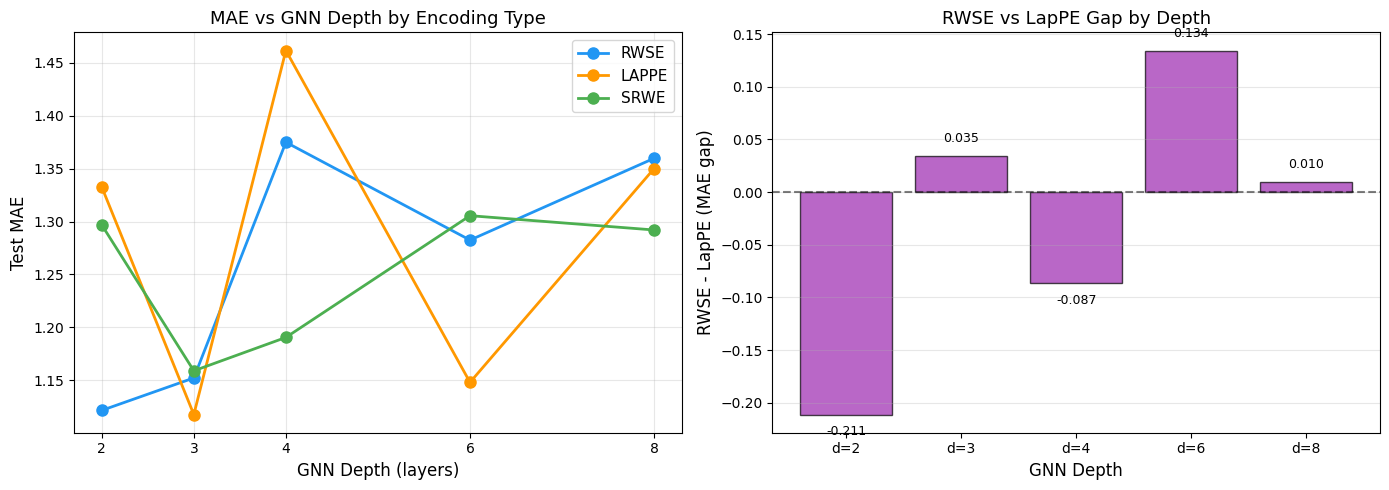

Figure saved to depth_vs_encoding_results.png


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: MAE by depth for each encoding
ax1 = axes[0]
colors = {"rwse": "#2196F3", "lappe": "#FF9800", "srwe": "#4CAF50"}
for pe_type in PE_TYPES:
    depths_plot = []
    maes_plot = []
    for d in sorted(DEPTHS):
        rk = (d, pe_type)
        if rk in results:
            valid = [m for m in results[rk] if not np.isnan(m)]
            if valid:
                depths_plot.append(d)
                maes_plot.append(np.mean(valid))
    if depths_plot:
        ax1.plot(depths_plot, maes_plot, 'o-', label=pe_type.upper(),
                color=colors.get(pe_type, 'gray'), linewidth=2, markersize=8)

ax1.set_xlabel("GNN Depth (layers)", fontsize=12)
ax1.set_ylabel("Test MAE", fontsize=12)
ax1.set_title("MAE vs GNN Depth by Encoding Type", fontsize=13)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(sorted(DEPTHS))

# Plot 2: RWSE-LapPE gap by depth
ax2 = axes[1]
if gap_by_depth:
    depths_gap = sorted(gap_by_depth.keys())
    gaps = [gap_by_depth[d] for d in depths_gap]
    ax2.bar(range(len(depths_gap)), gaps, color='#9C27B0', alpha=0.7, edgecolor='black')
    ax2.set_xticks(range(len(depths_gap)))
    ax2.set_xticklabels([f"d={d}" for d in depths_gap])
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax2.set_xlabel("GNN Depth", fontsize=12)
    ax2.set_ylabel("RWSE - LapPE (MAE gap)", fontsize=12)
    ax2.set_title("RWSE vs LapPE Gap by Depth", fontsize=13)
    ax2.grid(True, alpha=0.3, axis='y')

    # Annotate
    for i, (d, g) in enumerate(zip(depths_gap, gaps)):
        ax2.annotate(f"{g:.3f}", (i, g), textcoords="offset points",
                    xytext=(0, 10 if g >= 0 else -15), ha='center', fontsize=9)
else:
    ax2.text(0.5, 0.5, "No gap data", transform=ax2.transAxes, ha='center')

plt.tight_layout()
plt.savefig("depth_vs_encoding_results.png", dpi=100, bbox_inches="tight")
plt.show()
print("Figure saved to depth_vs_encoding_results.png")